In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from sklearn.decomposition import PCA
import sklearn.decomposition

import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
%matplotlib inline

<div class="span5 alert alert-info">
<h2>Notebook details</h2>

<p> This notebook is for <b>Clustering</b> for <b>Mortagage custome segementation</b> project.</p>
<p> The records are choosen by test and train. The loan amount is considerd as one feature. The salary and loan are used as amount</p>
<p> Notes.</p>
<ol>
<li>Apply K Mean clustering algorithm to the data</li>
<li>Apply methods to choose best value of K</li> 
    <ul>
     <li>The Elbow Sum-of-Squares Method</li>
     <li>The Silhouette Method </li>
    </ul>
<li>Consider K Mean as baseline analysis </li>
<li>Apply test train split to reduce data size to one million records</li>
        
</ol>
</div>

## Helper methods

In [2]:
# get K mean for no of cluster 
def getKmeansForCluster(noOfCluster, randomstate=1):
    kmean = KMeans(n_clusters=noOfCluster, random_state=randomstate)
    return kmean 

In [3]:
# get the fit predcit for k mean 
def getFitPredictForAlgo(algo,xcols):
    kmeans_val =algo.fit_predict(xcols)
    return kmeans_val

In [4]:
# get the data frame  with PCA with component dimension and K mean for 
#one component as all x cols and another component as the unique value
# this provides the clutser for each row in data frame 
def getPCADataFrame(df,noOfCluster,kmeans_val,xcols,componetNum=2):
    pca = PCA(n_components = componetNum)
    matrix = np.matrix(pca.fit_transform(xcols))
    df_pca_matrix = pd.DataFrame(matrix)
    df_pca_matrix.columns = ['x','y']

    df_clusters = pd.DataFrame(df.iloc[:,0])
    #df_clusters['x'], df_clusters['y'] = df_pca_matrix['x'], df_pca_matrix['y']
    #df_clusters['cluster_label'] = kmeans_val
    #df_clusters['x']  = np.NAN
    df_clusters['x']  = df_pca_matrix['x'].values
    #df_clusters['y']  = np.NAN
    df_clusters['y']  = df_pca_matrix['y'].values
    df_clusters['cluster_label'] = kmeans_val

    return df_clusters

In [5]:
# method to draw average silhouette score as graph for ranges of clusterand avg score calculated
def drawAverageSilhouetteScore(range_n_clusters,silhouette_avgscores):
        fig, axis = plt.subplots(1,1,figsize=(6,6),dpi=100)
        _ = plt.plot(range_n_clusters,silhouette_avgscores)
        _ = plt.xlabel('$K$')
        _ = plt.ylabel('Average Silhouette Score')
        _ = plt.title('Average Silhouette Scores for Agglomerative Clustering')

In [6]:
# draw bar graph for number of rows for each cluster X axis(cluster number), Y axis(no of rows in each cluster)
def drawClusterBar(noOfCluster,kmeans_val):
    cluster_kmeans_val = pd.Series(kmeans_val).value_counts().sort_index()
    #print(cluster_kmeans_val5)

    fig, axis = plt.subplots(1,1,figsize=(6,6),dpi=100)
    _ = cluster_kmeans_val.plot(kind='bar')
    _ = plt.ylabel('Number of Points')
    _ = plt.xlabel('Cluster')
    _ = plt.title('No of points for Clusters($K$ = '+str(noOfCluster)+')')

In [7]:
# draw cluster point on graph for each cluster . depends on data frame created PCA
def drawClusterPlot(df_clusters):
    axis = sns.lmplot(data=df_clusters, x='x', y='y', hue='cluster_label', 
                   fit_reg=False, legend=True, legend_out=True,size=10)
    _ = axis.set_axis_labels("Component 1", "Component 2")

In [8]:
# draw elbow plot to get the best component value for PCA
def drawElbowPCAplot(xcols):
    pca = sklearn.decomposition.PCA()
    pca.fit(xcols)
    fig, axis = plt.subplots(1,1,figsize=(12,6),dpi=100)
    _ = plt.plot(pca.explained_variance_)
    _ = plt.xlabel('$K$')
    _ = plt.xticks(range(0,33,1))
    _ = plt.xlim([0,31])
    _ = plt.ylabel('Explained Variance')
    _ = plt.title('Elbow Plot')

In [9]:
# To reduce the size of data set and allow the code to analyze cluster in each state the data frame filtered by State
def getDataFrameforState(inputframe,stateName='CA'):
    df=inputframe[inputframe.StateName==stateName]
    df=df[df.Accepted>0]
    # create index in wrangling
    #df = df.reset_index()
    return df

In [10]:
def getAllcolNameforDataframe(df, isSep=False):
    rownum=0
    for col in df:
        if(isSep):
            print("'"+str(col)+"',")
        else:
            print(str(rownum)+":"+str(col))
        rownum=rownum+1

In [11]:
def getAllColSum(df):
    for col in df:
        col_sum=sum(df[col])
        col_n=len(df[col])
        print('Sum of col : '+ col +' is '+str(col_sum) + ' total of col is ' +str(col_n))

In [12]:
def compareColForDataFrame(df1,df2):
    for col in df1:
        col_sum1=sum(df1[col])
        #col_n1=len(df1[col])
        #print('Sum of col : '+ col +' is '+str(col_sum) + ' total of col is ' +str(col_n))
        col_sum2=sum(df2[col])
        #col_n2=len(df2[col])
        diff =col_sum1-col_sum2
        tot=col_sum1+col_sum2
        print('Sum of col  : '+ col +' is '+str(col_sum1) + ' vs ' +str(col_sum2) +' diff ='+str(diff)+ ' ratio col1 :'+str((col_sum1/tot)))
    

In [13]:
def getFilterDatasetForRowCount(df,noofRows,random=True, samplesize=0.5):
    if(len(df)>noofRows):
        if(random):
            df1,df2=train_test_split(df, shuffle=True,train_size=samplesize,test_size=samplesize)
            if(len(df1)>noofRows):
                df=df1.iloc[:noofRows,:]
            else:
                 df=(df1.append(df2,ignore_index=True)).iloc[:noofRows,:]
        else:
            df=df.iloc[:noofRows,:]
    
    return df

In [14]:
# Method to convert the category column into dummy columns 
def AddDummyColumnsToDataFrame(dfinput,colname,removeOrgColumn=False,removelastdummy=False):
    print('Add {}'.format(colname))
    temp =pd.get_dummies(dfinput[colname])
    # remove one column from dummies with least value.
  
    if removelastdummy:
        t=dfinput.groupby(colname).count().state
        col_name=((t[t.values==t.min()]).index).get_values()[0]
        if col_name in temp.columns:
            print('removed column {}'.format(col_name))
            temp=temp.drop([col_name], axis=1)
    
    # remove the main column after extracting dummy
    if removeOrgColumn:
        if colname in dfinput.columns:
            print('removed column {}'.format(colname))
            dfinput =dfinput.drop([colname], axis=1)
    else:
        print('left column {} in dataframe'.format(colname))
        
        
    for col in temp:
        temp.rename(columns={col: colname+'_'+str(col)}, inplace=True)
    
    return  pd.concat([dfinput,temp], axis=1,ignore_index=False)

### Processing Starts

 # with Amt bins

### Processing Starts

In [15]:
aag_predict_col={}
aag_silh_score={}
pickle_file_sil='AgglomerativeClustering/silhouette_avgscores_AgglomerativeClustering _ML.sa'
aag_silh_score = pickle.load( open( pickle_file_sil, "rb" ) )
pickle_file_sample='AgglomerativeClustering/silhouette_samples_AgglomerativeClustering _ML.sa'
aag_predict_col = pickle.load( open( pickle_file_sample, "rb" ) )
pickle_file='AgglomerativeClustering/pickle_selectdata_ML_All_Col_CA_AfterKmean.sa'
df_filterdata = pickle.load( open( pickle_file, "rb" ) )
range_n_clusters = range(2,11)

In [16]:
aag_silh_score

{2: 0.16160281488398204,
 3: 0.19200136867411574,
 4: 0.20501229158972623,
 5: 0.14875852177530208,
 6: 0.12842847415160943,
 7: 0.13285369499495783,
 8: 0.13445390390989231,
 9: 0.1455726098362693,
 10: 0.1395009173618812}

In [17]:
aag_predict_col

{2: array([1, 1, 1, ..., 0, 1, 0], dtype=int64),
 3: array([1, 1, 1, ..., 2, 1, 2], dtype=int64),
 4: array([0, 0, 0, ..., 2, 0, 2], dtype=int64),
 5: array([4, 4, 2, ..., 0, 4, 0], dtype=int64),
 6: array([4, 4, 0, ..., 2, 4, 2], dtype=int64),
 7: array([4, 4, 6, ..., 0, 4, 0], dtype=int64),
 8: array([4, 4, 6, ..., 2, 4, 7], dtype=int64),
 9: array([1, 1, 6, ..., 2, 1, 7], dtype=int64),
 10: array([0, 0, 6, ..., 2, 0, 7], dtype=int64)}

In [18]:
# create common x for all further processing for all feature columns 
x_cols = np.matrix(df_filterdata.iloc[:,69:])

In [19]:
print(len(df_filterdata))
print (len(df_filterdata.index.unique()))
print(len(x_cols))

#range_n_clusters = range(2,14)
# print(len(df_filterdata_NR))
# print (len(df_filterdata_NR.index.unique()))
# print(len(x_cols_NR))

100000
100000
100000


## Agglomerative Clustering


* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>

<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>

</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

In [20]:
#Agglomerative Clustering
print(str(datetime.datetime.now()))
#find the best value for n_clusters parameter. 
best_score = 0.0
for n_clusters in range_n_clusters:
#     ac = getAlgoForCluster('algocluster', n_clusters)#AgglomerativeClustering(n_clusters=n_clusters)
#     #labels = ac.fit_predict(x_cols)
#     labels = getFitPredictForAlgo(ac,x_cols)
    if n_clusters not in aag_predict_col:
        print("For n_clusters =", n_clusters," the label is not found ")
#     silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    if n_clusters not in aag_silh_score:
         print("For n_clusters =", n_clusters," the silhouette_score is not found ")
    else:
        silhouette_avg=aag_silh_score[n_clusters]
    
        
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
print ('Best AgglomerativeClustering score is', best_score)
print(str(datetime.datetime.now()))

2018-07-23 20:03:21.947442
For n_clusters = 2 The average silhouette_score is : 0.16160281488398204
For n_clusters = 3 The average silhouette_score is : 0.19200136867411574
For n_clusters = 4 The average silhouette_score is : 0.20501229158972623
For n_clusters = 5 The average silhouette_score is : 0.14875852177530208
For n_clusters = 6 The average silhouette_score is : 0.12842847415160943
For n_clusters = 7 The average silhouette_score is : 0.13285369499495783
For n_clusters = 8 The average silhouette_score is : 0.13445390390989231
For n_clusters = 9 The average silhouette_score is : 0.1455726098362693
For n_clusters = 10 The average silhouette_score is : 0.1395009173618812
Best n_clusters parameter: 4
Best AgglomerativeClustering score is 0.20501229158972623
2018-07-23 20:03:21.949451


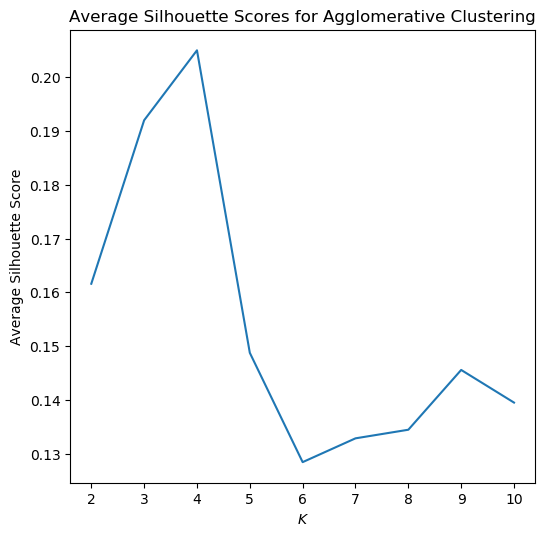

In [21]:
# draw graph for all above silhouette_score
drawAverageSilhouetteScore(range_n_clusters,aag_silh_score.values() )

### Visualize cluster for range

AgglomerativeClustering/pickle_AggClu_All_Col_CA_Cluster_2.sa
AgglomerativeClustering/pickle_AggClu_All_Col_CA_Cluster_3.sa
AgglomerativeClustering/pickle_AggClu_All_Col_CA_Cluster_4.sa
AgglomerativeClustering/pickle_AggClu_All_Col_CA_Cluster_5.sa
AgglomerativeClustering/pickle_AggClu_All_Col_CA_Cluster_6.sa
AgglomerativeClustering/pickle_AggClu_All_Col_CA_Cluster_7.sa
AgglomerativeClustering/pickle_AggClu_All_Col_CA_Cluster_8.sa
AgglomerativeClustering/pickle_AggClu_All_Col_CA_Cluster_9.sa
AgglomerativeClustering/pickle_AggClu_All_Col_CA_Cluster_10.sa


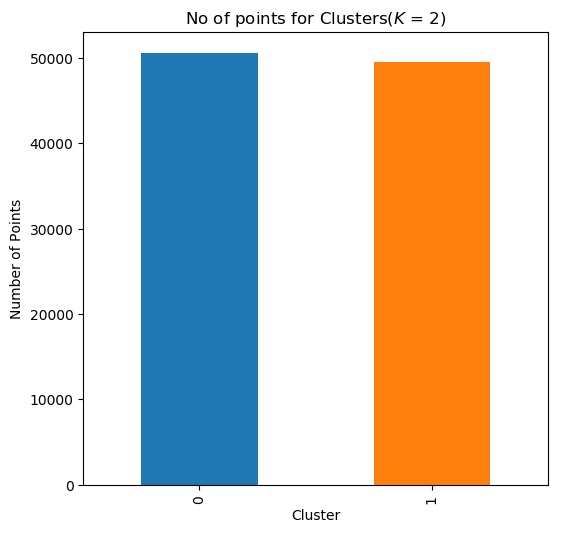

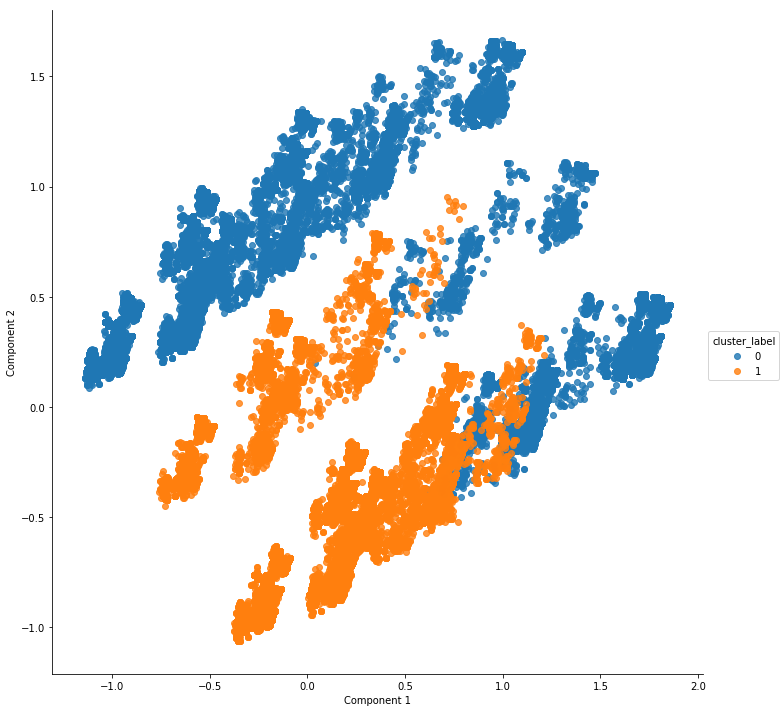

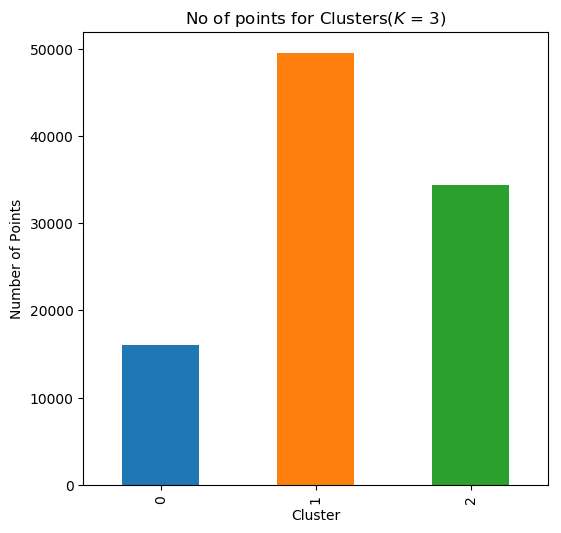

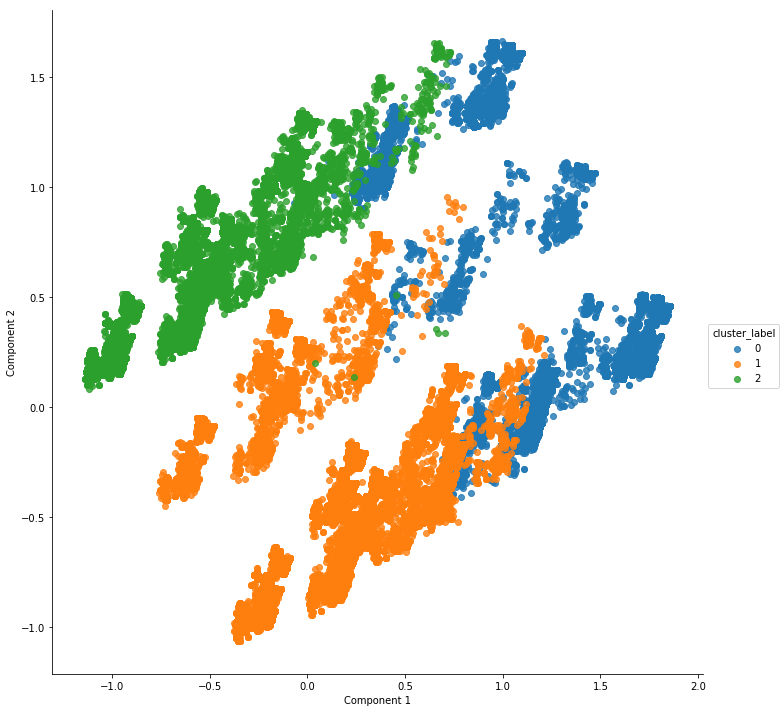

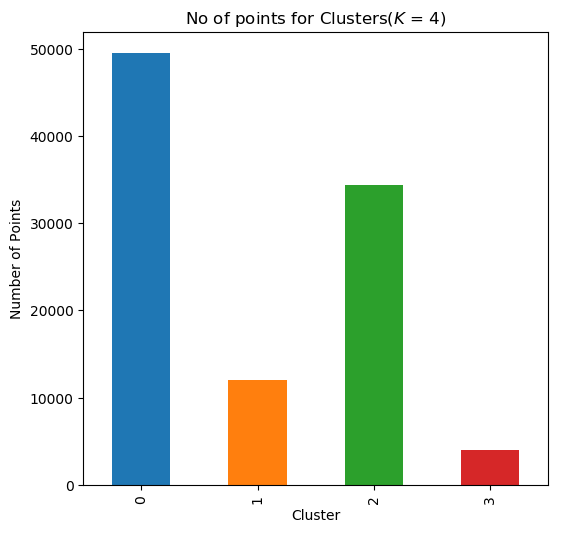

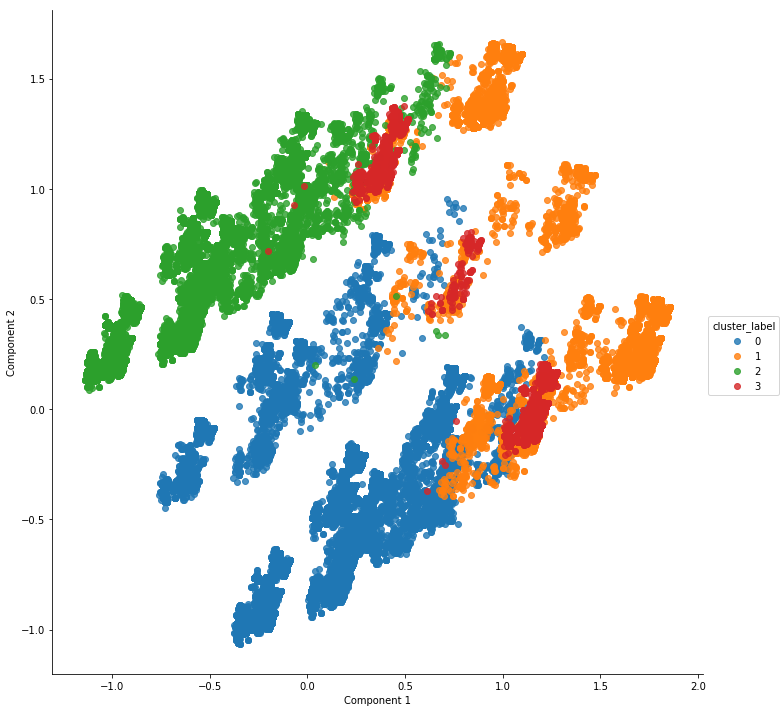

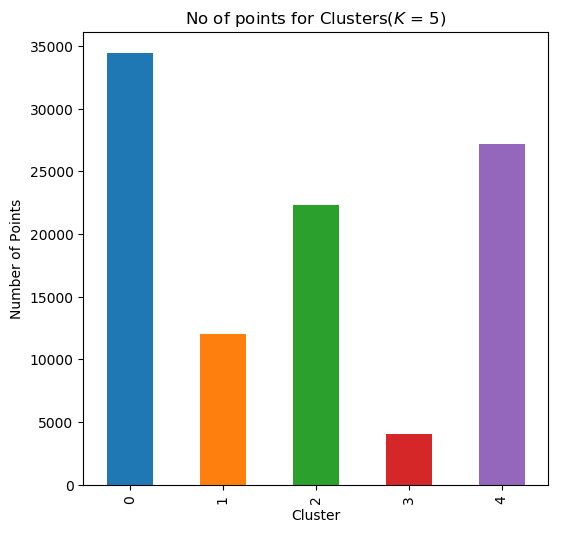

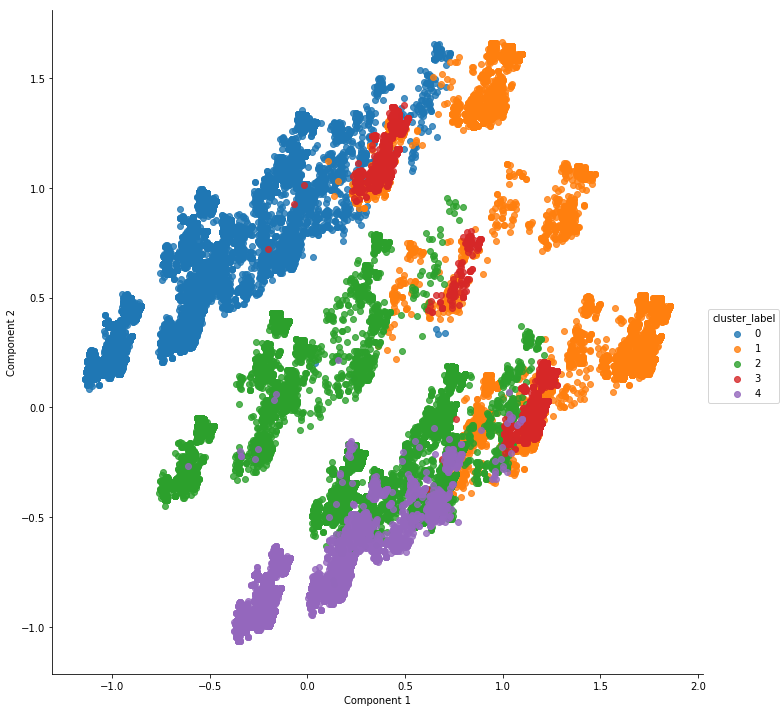

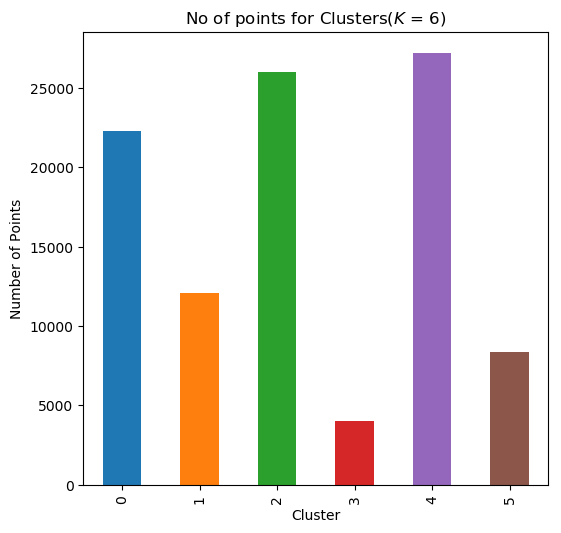

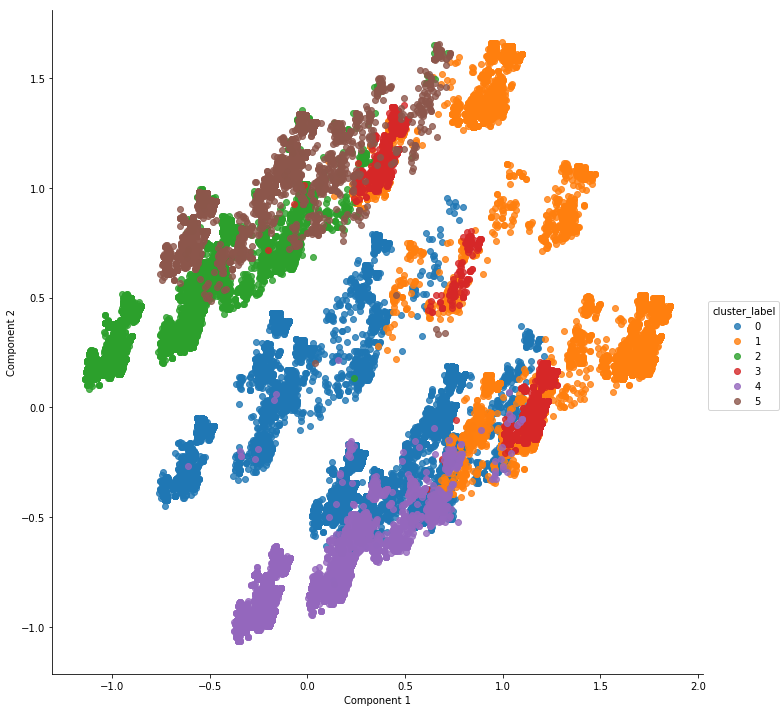

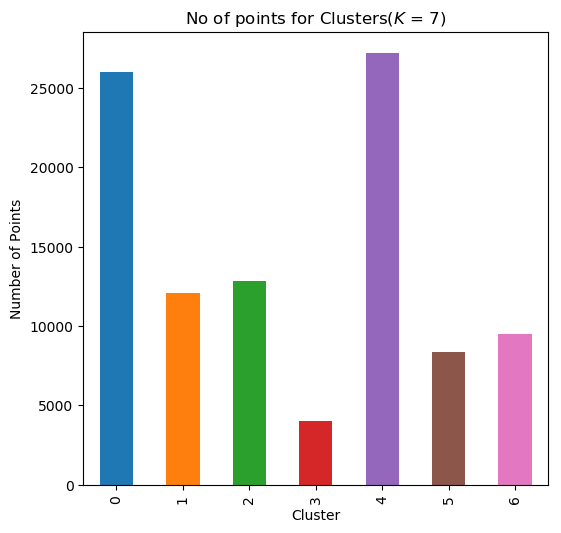

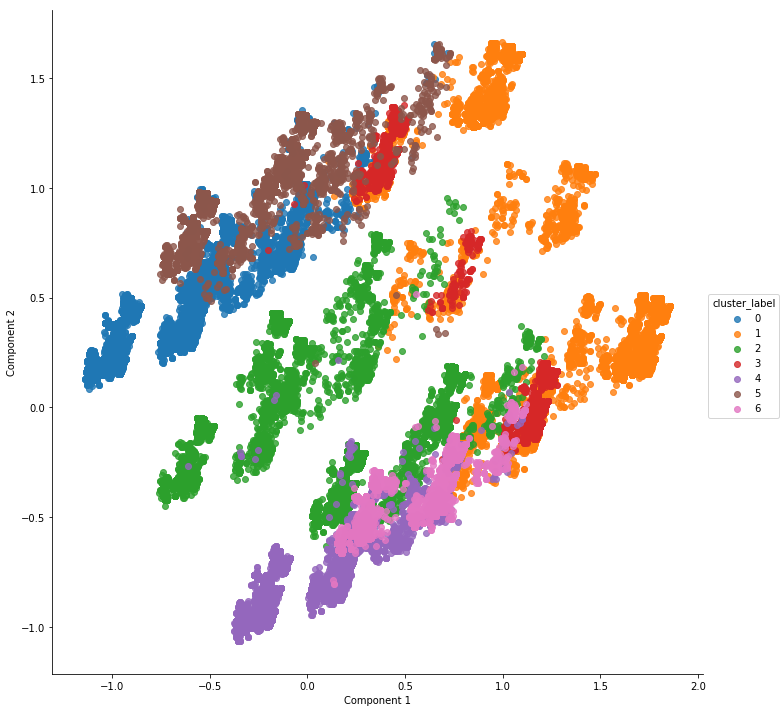

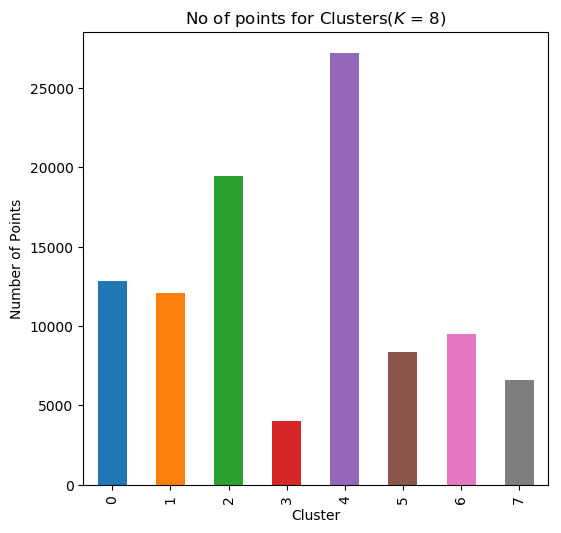

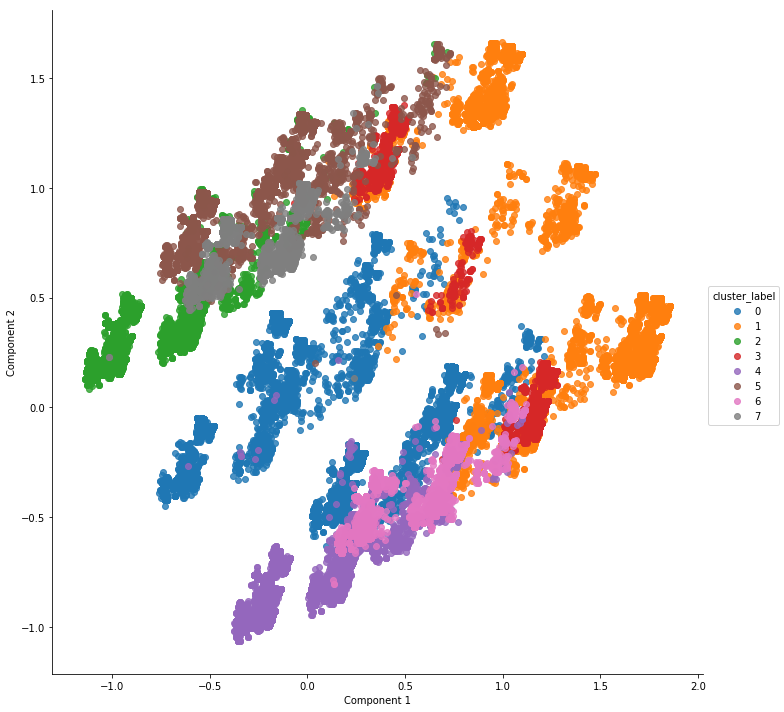

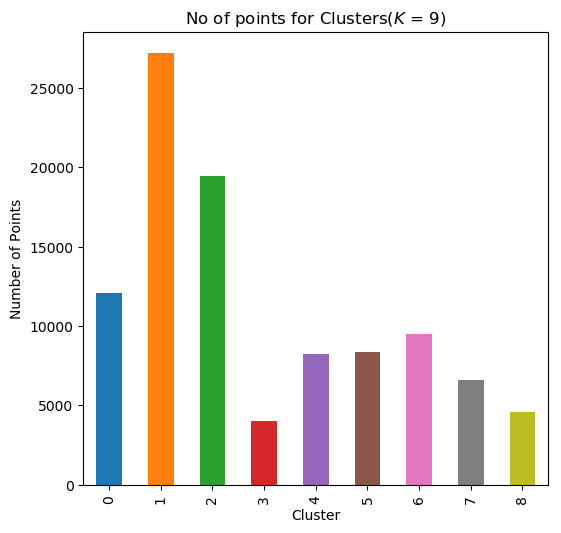

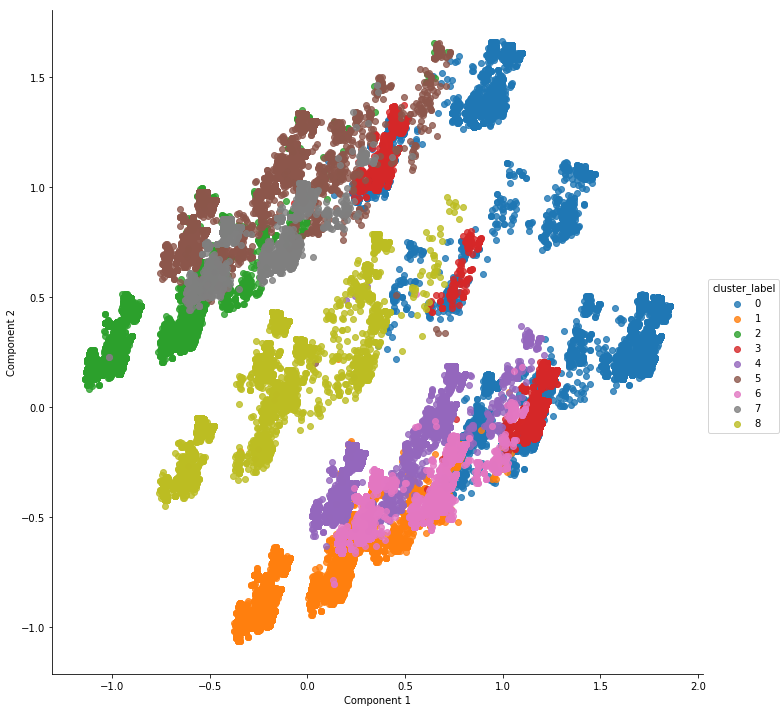

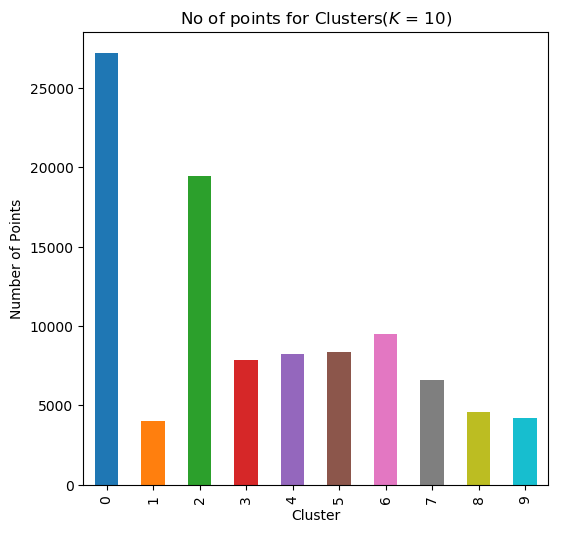

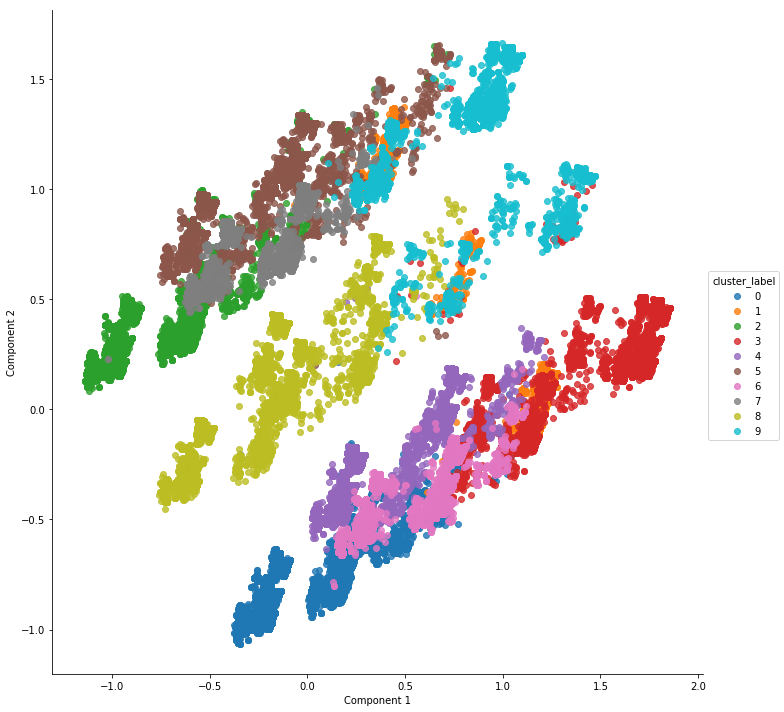

In [22]:
for noofcluster in range_n_clusters:#[5,6,8,9,11]:#:range_n_clusters:
    if noofcluster in aag_predict_col:
        algo_val=aag_predict_col[noofcluster]
    else:
        algo_val = getFitPredictForAlgo(getAlgoForCluster('algocluster', noofcluster),x_cols)
    drawClusterBar(noofcluster,algo_val)
    df_PCA=getPCADataFrame(df_filterdata,noofcluster,algo_val,x_cols)
    drawClusterPlot(df_PCA)
    df_merge_w_cluster=pd.merge(df_filterdata, df_PCA,
                                left_on = 'index', right_on = 'index',how='inner')
    # save file for all clusters
    picklefilename='AgglomerativeClustering/pickle_AggClu_All_Col_CA_Cluster_'+str(noofcluster)+'.sa'
    print(picklefilename)
    # create pickle file for further use 
    pickle.dump(df_merge_w_cluster,open(picklefilename,'wb'), protocol=4)

In [23]:
drawElbowPCAplot(x_cols_wbins)

NameError: name 'x_cols_wbins' is not defined

In [ ]:
## END##

In [ ]:
#help(KMeans)